In [128]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math
import random
import pandas as pd

random.seed('Ich hasse die Kalman-Filter')

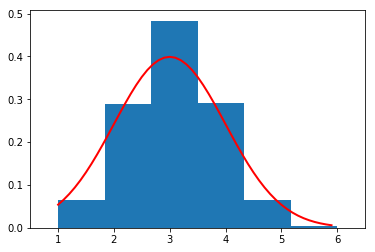

In [22]:
def gaussian(arg ,mu, sigma):
    '''Normalized Gaussian (Density) at position arg'''
    return (1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (arg - mu)**2 / (2 * sigma**2) ))

def draw_grades(n, mu, sigma, lowest=1, highest=6):
    '''Samples n normally distributed integers (grades)'''
    max_value = gaussian(mu, mu, sigma)
    random_grade = -1
    grades = []
    while len(grades) < n:
        random_grade = random.randint(lowest,highest)
        if random.random() < gaussian(random_grade, mu, sigma)/max_value:
            grades.append(random_grade)
    return(grades)

def draw_single(mu, sigma, lowest=1, highest=6):
    '''Samples n normally distributed integers (grades)'''
    max_value = gaussian(mu, mu, sigma)
    random_grade = -1
    grade = None
    while grade == None:
        random_grade = random.randint(lowest,highest)
        if random.random() < gaussian(random_grade, mu, sigma)/max_value:
            grade = random_grade
    return(grade)

mu, sigma = 3 , 1 # mean and standard deviation
lowest = 1
highest = 6
grades = draw_grades(100000, mu, sigma, lowest, highest)

count, bins, ignored = plt.hist(grades, 6, normed=True, align='mid')

xs = np.arange(lowest, highest, 0.1)

plt.plot(xs, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (xs - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.xlim((lowest-0.5,highest+0.5))
plt.show()

In [101]:
def next_grade_model(mu, mediocre=3, k=0.01):
    '''calculates the theoretical estimate for the new mean.
    
    The model assumes, that grades will generally tend to a mediocre value.
    So if the mean is high it will go down in the next step and go up if the grade was lower.
    The change is linear to the distance of the two values.'''

    return(mu - k)
    #return(mu + k * (mediocre - mu))

In [102]:
def kalman_filter(state, hidden_state, gain, sigma_transition=1, sigma_measurement=1, noisy_transition=False):
    '''calculates estimate for next state, based on a noisy measurement and a state-transition model.
    Returns also the transition of a given "true" (hidden) value and the measurement of this true value (noisy)
    for comparison.'''
    transition = next_grade_model(state)
    if noisy_transition == True:
        transition_noise = transition - draw_single(transition, sigma_transition)
    else:
        transition_noise = 0
    
    measurement = draw_single(hidden_state, sigma_measurement)
    next_hidden = next_grade_model(hidden_state)
    
    estimate = transition + gain * (measurement - (transition + transition_noise))
    
    return(estimate, next_hidden, measurement)

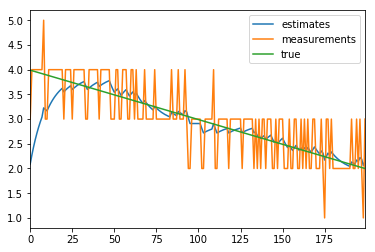

In [137]:
hidden_state = 4

gain = 0.1
sigma_transition = 0
sigma_measurement = 0.5

current_measurement = draw_single(hidden_state, sigma_measurement)
current_state = 2 # current_measurement, Zur Demonstration hart gecoded
n = 200

measurements = []
estimates = []
true = []

for i in range(n):
    estimate, next_hidden, measurement = kalman_filter(current_state, 
                                                       hidden_state,
                                                       gain,
                                                       sigma_transition=sigma_transition,
                                                       sigma_measurement=sigma_measurement)
    measurements.append(measurement)
    estimates.append(estimate)
    true.append(next_hidden)
    
    hidden_state = next_hidden
    current_measurement = draw_single(hidden_state, sigma_measurement)
    current_state = estimate

measurement_cycle = pd.DataFrame(
    {'measurements': measurements,
     'estimates': estimates,
     'true': true
    })

measurement_cycle.plot()

plt.show()

In [122]:
matrix = measurement_cycle.as_matrix()

In [92]:
matrix

array([[ 4.999,  6.   ,  3.998],
       [ 3.499,  3.   ,  3.996],
       [ 4.499,  5.   ,  3.994],
       ..., 
       [ 1.499,  1.   ,  2.204],
       [ 1.999,  2.   ,  2.202],
       [ 1.999,  1.   ,  2.2  ]])

In [123]:
(matrix[:,0].mean(),matrix[:,1].mean(),matrix[:,2].mean())

(2.995000000000021, 2.9750000000000001, 2.995000000000021)

In [117]:
(matrix[:,0].var(),matrix[:,1].var(),matrix[:,2].var())

(0.48420000000000002, 0.60959999999999992, 0.33332499999998577)